<a href="https://colab.research.google.com/github/Mario-td/HandGestureClassification/blob/master/3DModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D model selection**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
import time
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Path to the files
path = '/content/drive/My Drive/MastersThesis/Dataset/'
data3D = pd.read_csv(path + '/HandGesture3D.csv')

In [ ]:
# Get the number of frames per sample
t_steps = max(data3D['Sequence']) + 1
t_steps

32

In [ ]:
# Get the labels
Y_ = np.array(data3D['Label'][0::t_steps][:], dtype=np.int32)
Y_.size

13604

In [ ]:
# Get the data
X_3D = pd.DataFrame.to_numpy(data3D[data3D.columns[2:]])
# Split into the number of samples
X_3D = np.array(np.split(X_3D, Y_.size))
X_3D.shape

(13604, 32, 63)

In [ ]:
# Splits into train and test
X_train3D, X_test3D, y_train3D, y_test3D = train_test_split(X_3D, Y_, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape '+ str(X_train3D.shape))
print('X_test shape '+ str(X_test3D.shape))

X_train shape (10883, 32, 63)
X_test shape (2721, 32, 63)


In [ ]:
# Prints the number of samples per class in the training and test set
n_classes = 5 
for i in range(n_classes):
  print('train samples %d: ' % i + str(np.count_nonzero(y_train3D == i)))
print('----------------------')
for i in range(n_classes):
  print('test samples %d: ' % i + str(np.count_nonzero(y_test3D == i)))

train samples 0: 2090
train samples 1: 2164
train samples 2: 2211
train samples 3: 2140
train samples 4: 2278
----------------------
test samples 0: 554
test samples 1: 544
test samples 2: 537
test samples 3: 548
test samples 4: 538


In [ ]:
# Adjusts the label arrays shape
y_train3D = tf.keras.utils.to_categorical(y_train3D, n_classes)
y_test3D = tf.keras.utils.to_categorical(y_test3D, n_classes)

In [ ]:
# Number of input parameters per timestep
n_input3D = len(X_train3D[0][0])
# Reshapes the input splitting it into subsequences
n_sub = 2
n_length = (int) (t_steps / n_sub)
X_train3D = X_train3D.reshape((X_train3D.shape[0], n_sub, n_length, n_input3D))
X_test3D = X_test3D.reshape((X_test3D.shape[0], n_sub, n_length, n_input3D))

In [ ]:
# Defines the model
model_3D = tf.keras.Sequential()
model_3D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_sub,  n_length, n_input3D)))
model_3D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_3D.add(tf.keras.layers.Dropout(0.4))
model_3D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model_3D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model_3D.add(tf.keras.layers.LSTM(200))
model_3D.add(tf.keras.layers.Dropout(0.4))
model_3D.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

# **Model training**

In [ ]:
# Hyperparameters
batch_size = 1024
n_epochs = 80
opt = tf.keras.optimizers.Adam(learning_rate=0.0013, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_3D.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

# Measures the training time
t_start = time.time()
history = model_3D.fit(X_train3D, y_train3D, shuffle=True, batch_size=batch_size, epochs=n_epochs)
t_stop = time.time() 
print( "Training time: " + str(datetime.timedelta(seconds= t_stop - t_start)))

Epoch 1/80
 1/11 [=>............................] - ETA: 0s - loss: 1.6105 - accuracy: 0.2305WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
11/11 [==============================] - 3s 235ms/step - loss: 1.4548 - accuracy: 0.4139
Epoch 2/80
11/11 [==============================] - 3s 232ms/step - loss: 1.0159 - accuracy: 0.6172
Epoch 3/80
11/11 [==============================] - 3s 233ms/step - loss: 0.8729 - accuracy: 0.6662
Epoch 4/80
11/11 [==============================] - 2s 225ms/step - loss: 0.6975 - accuracy: 0.7439
Epoch 5/80
11/11 [==============================] - 2s 225ms/step - loss: 0.5970 - accuracy: 0.7801
Epoch 6/80
11/11 [==============================] - 2s 226ms/step - loss: 0.5349 - accuracy: 0.8007
Epoch 7/80
11/11 [======================

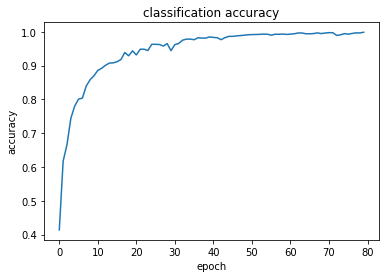

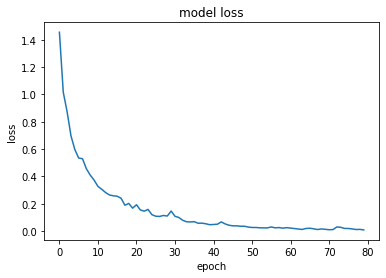

In [ ]:
# Summarizes history for accuracy
plt.plot(history.history['accuracy']) 
plt.title('classification accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.show()

# Summarizes history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# **Model evaluation**

In [ ]:
model_3D.evaluate(X_test3D, y_test3D)

86/86 [==============================] - 1s 6ms/step - loss: 0.0139 - accuracy: 0.9978


[0.013942551799118519, 0.9977949261665344]

In [ ]:
predicted_classes = model_3D.predict_classes(X_test3D) 
# Sets the actual test label with the same format
y_test3D = y_test3D.argmax(1)

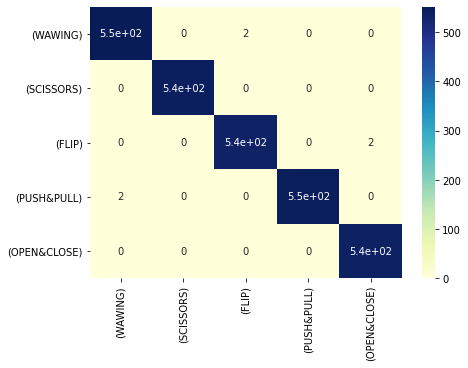

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Label of the classes
LABELS = [    
    '(WAWING)',
    '(SCISSORS)',
    '(FLIP)',
    '(PUSH&PULL)',
    '(OPEN&CLOSE)'
] 

cm = confusion_matrix( y_test3D, predicted_classes)
cm
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True, xticklabels = LABELS, yticklabels = LABELS, cmap="YlGnBu")

In [ ]:
# Saves the parameters
model_3D.save_weights(path + 'WEIGHTS-3D.ckpt')
model_3D.save(path + 'MODEL-3D.h5')